### KEM
This is a simulation of an economic micro interations, in which each time step two actors, which are chosen by an interaction function, engage in a transaction that exchanges wealth between them according to a specific transaction function.

This code has been modified from https://nbviewer.jupyter.org/url/norvig.com/ipython/Economics.ipynb

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np
import copy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
warnings.filterwarnings("ignore")

In [8]:
class Agent():
    def __init__(self,income=0):
        self.income = income
        self.lambda_ = .5 
        
class Agents():
    def __init__(self):
        self.agents = []
    def get_agent(self,n):
        return self.agents[n]

In [9]:
ags = Agents()
ags.agents = [Agent(income=100),Agent(income=200),Agent(income=300)]

In [10]:
ags.get_agent(1).income = -100



In [11]:
for agent in ags.agents:
    print(agent.income)

100
-100
300


In [2]:
class General_Model_MultiCity(object):

    #TODO:
    
    def run_many_pops(self)
    
        # generated by zipf's law distribution
        hists = []
        popsizes = np.unique(np.random.zipf(1.4,300)*100)[:-8]
        for popsize in popsizes:
            population,lambda_ = generate_population(popsize)
            print("\n NEW SIM\npopulation = ",popsize)
            results,_,_ = run(population,k=200)
            hists.append(results[-1])
        #     test_stability(results)


        fig = plt.figure()
        
        
    def animate_population_dists(self):
        
        def animate(i):
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            lbl = "population = "+str(popsizes[i])
            plt.hist(hists[i], alpha = 0.4, bins = 30, label=lbl)
            plt.legend()
            plt.xlabel('Wealth')
            plt.ylabel('Count')
            plt.grid(True)

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       #frames=76)#), interval=20)#, blit=True)
                                       frames=len(hists))#), interval=20)#, blit=True)
        HTML(anim.to_jshtml())

SyntaxError: invalid syntax (<ipython-input-2-19c952a7c319>, line 5)

In [82]:
# General Simulation Class

class Super_General_Model(object):
    
    def __init__(self,N=500,mu=100.):
        self.N = N
        self.populate(N,mu)
        self.time = 0
        self.mu = mu
    
    def populate(self,N,mu=100.):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        pass
    
    
    class agent:
        def __init__(self,income=0.):
            self.income = income      
        
    
    def choose_agents(self):
        """
        Input: None
        
        Output: A pair of agents who are going to interact. This becomes the input to interact
        """
        pass
    
    def interact(self,agents):
        """
        Input: Return value of choose_agents, the agents to interact
        
        Output: list of agent incomes
        
        Changes selected agent incomes/wealths according to KEM interaction mechanism and return new distribution
        """
        pass

    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        pass
    
    
    def simulate(self, steps):
        '''
        Simulate takes a certain initial population, and makes them interact.

        Inputs:
            population. list. Initial income distribution
            steps. int. Time steps to execute the simulation
            transaction. function. function that describes the dynamic of the transaction.
            interaction. function. function that describes the dynamic of the interaction.

        Outputs:
            population after steps number of steps. 

        '''
        
        print(np.array([a.lambda_ for a in self.population]))
        for t in range(steps):
            prev = np.array(self.get_income_dist())
            print(prev)
            to_interact = self.choose_agents()
            new_distribution = self.interact(to_interact)
            diff = (np.array(new_distribution) - prev)/prev
            nz = np.nonzero(diff)
            lams = np.array([a.lambda_ for a in self.population])
            for dif,lam in zip(diff[nz],lams[nz]):
                if dif < 0:
                    if dif > (1-lam):
                        print("I THINK THAT'S WRONG")
            print("diff",diff)
#             print("lambdas:",lams[nz])
            yield new_distribution

            
    def reset(self):
        self.populate(self.N,self.mu)
            
            
    def run(self, k=500, **kwargs):

        '''
        Run a simulation for k*N steps, returning results

        '''

        N = self.N
        start = self.get_income_dist()

        #TODO: Make sure this doesn't get added to repeatedly
        self.results = [start]
        
        for (t, pop) in enumerate(self.simulate(k * N, **kwargs)):
            self.time += 1
            if t % (N / 10) == 0:
                self.results.append(copy.copy(pop))

        return self.results
    
    
    
    ####################### ANALYSIS ##################################
    
    
    def gini(self,p):

        "Gini coefficient (equation from wikipedia)"

        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n


    def hist(self, population, label='Dist', **kwargs):
        label = label + ': G=' + str(round(self.gini(population), 2))

        h = plt.hist(list(population), alpha = 0.4, bins = 30, label= label, **kwargs)

        plt.xlabel('Wealth')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()


    def show(self, percentiles=(1, 10, 50, 90, 99), **kwargs):

        '''
        print statistics and display a plot and histogram.

        '''

        if self.time == 0:
            print("ERROR: HASN'T RUN YET!")
            return

        # Statistics

        print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))


        fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
  
        initsum = self.N*self.mu
        t = 0
        for pop in self.results:
            t += 1
            pop = sorted(pop)
            if t % (4 * self.N) == 0:
                data = [self.percent(pct, pop) for pct in percentiles]
                print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))


    #     #plot individual trajectory
    #     plt.hold(True)
    #     plt.xlabel('Time')
    #     plt.ylabel('Wealth')
    #     plt.grid(True)
    #     plt.plot(times, lists)

    #     plt.show()





        # Plot

    #     plt.xlabel('Time')
    #     plt.ylabel('Wealth')
    #     plt.grid(True)

    #     for pct in percentiles:
    #         #TODO: this should average over all people in different percentiles, or make a separate thing to do that
    #         line = [percent(pct, pop) for pop in results]
    #         plt.plot(times, line)

    #     plt.show()


        # Histogram
        start = self.results[0]
        pop = self.results[-1]
        #R = (min(pop), max(pop))
        R = (min(pop+start), max(pop+start))
        self.hist(start, 'Initial', range=R)
        self.hist(pop, 'Final', range=R)
        plt.show()
        plt.close()
        
        

    def normalize(self,numbers, mu):

        '''
        Positive values, and scale them so they have mean mu.

        '''

        numbers = [max(0, n) for n in numbers]

        factor = len(numbers) * mu / sum(numbers)

        return [x * factor for x in numbers]

    def samples(self,distribution, *args, n = None, mu = None):
        '''
        Sample from the distribution n times,
        then normalize results.

        '''
        if not n:
            n = self.N
        if not mu:
            mu = self.mu

        numbers = [distribution(*args) for _ in range(n)]
        return self.normalize(numbers, mu)


    def percent(self,pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]



    def animate_distributions(self,continuous=True,times=[0,1],n_frames=100):
        #if continuous:
        pop_series = self.results
        run_times = []


        duration = times[1]-times[0]
        tstep = round(float(duration)/n_frames)

        max_t = self.time

        fig = plt.figure()
        def animate(i):
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            time = times[0]+i*tstep
            if time < max_t:
                # take average 
                plotvals = np.average(pop_series[time:(time+tstep)],axis=0)
                plt.hist(plotvals, alpha = 0.4, bins = 30, label=str(time))
                plt.legend()
                plt.xlabel('Wealth')
                plt.ylabel('Count')
                plt.grid(True)

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       frames=n_frames)#), interval=20)#, blit=True)
        HTML(anim.to_jshtml())
        return anim



    def test_stability(self,n_steps=50,end_time=1000):
        pop_series = np.array(self.results)
        t_series = pop_series[(end_time-n_steps):end_time]
        stds = []
        mus = []
        for agent_n in range(len(t_series[0])):
            agent_series = t_series[:,agent_n]
            std = np.std(agent_series)
            stds.append(std)
            mus.append(np.mean(agent_series))
        plt.figure()
        plt.hist(stds)
        xlbl = "standard deviations of wealth (unit=absolute wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
        plt.xlabel(xlbl)
        plt.show()


        stds,mus = np.array(stds),np.array(mus)
        plt.figure()
        plt.hist((stds/mus))
        xlbl = "standard deviations of wealth (unit=percent wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
        plt.xlabel(xlbl)
        plt.show()
        
        plt.close()
        
        


In [83]:
# Simulation with purely random interactions

class Pure_Random(Super_General_Model):
    
    class Agent:
        def __init__(self,income=0.,lambda_=0.):
            self.income = income  
            self.lambda_ = lambda_
            

    #initial values (population size & mean of the income distribution)
    def populate(self,n=500,mu=100.):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        self.time = 0
        incomes = [np.random.uniform(0, mu*2.) for actor in range(n)]
        #lambda_ = np.random.uniform(0.1,0.8,n)
        lambda_ = np.random.power(0.3,n)
        print(max(lambda_))
        i = 0
        # make sure no lambdas are above 1
        for l in lambda_:
            if l >=1.:
                lambda_[i] = np.random.pareto(.3)
                if lambda_[i]>=1.:
                    lambda_[i] = 0.9
            i+=1
                
        self.population = []
        for inc,lam in zip(incomes,lambda_):
            self.population.append(self.Agent(income=inc,lambda_=lam))
        self.population = np.array(self.population)
    
  
    
    def choose_agents(self):
        """
        Input: None
        
        Output: A pair of agents who are going to interact. This becomes the input to interact
       
        Takes two actors randomly

        """
        loc_a,loc_b = random.sample(range(self.N), 2)
        return self.population[loc_a],self.population[loc_b]
    
    def get_lambda_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        return [a.lambda_ for a in self.population]
    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        return [a.income for a in self.population]
    
    
    def interact(self,agents):
        """
        Input: Return value of choose_agents, the agents to interact
        
        Output: list of agent incomes
        
        Changes selected agent incomes/wealths according to KEM interaction mechanism and return new distribution
        """
        eps = np.random.uniform()
        A,B = agents
        #print(id(A),id(B))
        A.income,B.income = A.lambda_*A.income + eps*((1-A.lambda_) * A.income + (1 - B.lambda_)*B.income), B.lambda_*B.income + (1-eps)*((1 - A.lambda_) * A.income + (1 - B.lambda_)*B.income) 
        #A.income,B.income = A.income+1.,B.income+1.
        return self.get_income_dist()


0.7692506326635863
[0.23950109 0.00850332 0.12201147 0.76925063 0.76469877]
[36.54313456 92.25946344 46.12543204 65.46899273  4.86917302]
diff [-0.2768228   0.          0.          0.          2.07755463]
[26.42716163 92.25946344 46.12543204 65.46899273 14.98514595]
diff [ 0.26971136  0.         -0.15452876  0.          0.        ]
[33.55486734 92.25946344 38.99772633 65.46899273 14.98514595]
diff [ 0.10569473  0.         -0.09094306  0.          0.        ]
[37.10144    92.25946344 35.45115367 65.46899273 14.98514595]
diff [ 0.          0.          0.          0.02729307 -0.1192414 ]
[37.10144    92.25946344 35.45115367 67.2558425  13.19829618]
diff [ 0.         -0.79871874  0.          0.          5.58324814]
[37.10144    18.57010086 35.45115367 67.2558425  86.88765876]
diff [ 0.          0.         -0.26110135  0.          0.10653232]
[37.10144    18.57010086 26.19480962 67.2558425  96.14400281]
diff [-0.71998925  0.          0.          0.39717944  0.        ]
[10.38880195 18.57010

[ 17.58600231  17.60687373  43.90460123 108.63295264  57.53576588]
diff [ 1.16955957  0.         -0.46846747  0.          0.        ]
[ 38.15387964  17.60687373  23.3367239  108.63295264  57.53576588]
diff [ 0.38101581  0.          0.         -0.13381972  0.        ]
[52.69111083 17.60687373 23.3367239  94.09572144 57.53576588]
diff [ 0.          0.94406469 -0.71226912  0.          0.        ]
[52.69111083 34.22890158  6.71469606 94.09572144 57.53576588]
diff [ 0.25240364  0.          0.          0.         -0.23115062]
[65.99053881 34.22890158  6.71469606 94.09572144 44.2363379 ]
diff [-0.05146261  0.          0.          0.03609139  0.        ]
[62.59449365 34.22890158  6.71469606 97.4917666  44.2363379 ]
diff [-0.10764836  0.          1.00349959  0.          0.        ]
[55.85629894 34.22890158 13.45289078 97.4917666  44.2363379 ]
diff [ 0.         -0.96946283  0.          0.          0.75014455]
[55.85629894  1.04525394 13.45289078 97.4917666  77.41998553]
diff [-0.24706133  0.    

diff [ 0.24611052  0.          0.         -0.1222428   0.        ]
[ 48.47304293   8.2153632   15.78811057  68.74245167 104.04722742]
diff [ 0.          0.          0.         -0.07542916  0.04983492]
[ 48.47304293   8.2153632   15.78811057  63.55726604 109.23241305]
diff [ 0.          0.          0.          0.28257037 -0.16441457]
[48.47304293  8.2153632  15.78811057 81.51666597 91.27301312]
diff [ 0.          0.         -0.64681211  0.12527427  0.        ]
[48.47304293  8.2153632   5.57616949 91.72860706 91.27301312]
diff [ 0.          2.39866637  0.         -0.21482846  0.        ]
[48.47304293 27.92127859  5.57616949 72.02269167 91.27301312]
diff [-0.6816395  0.         0.         0.         0.3620034]
[ 15.43190231  27.92127859   5.57616949  72.02269167 124.31415374]
diff [ 1.08142739 -0.59769763  0.          0.          0.        ]
[ 32.12038422  11.23279667   5.57616949  72.02269167 124.31415374]
diff [ 0.30896019 -0.88347721  0.          0.          0.        ]
[ 42.04430408  

diff [-0.57934082  0.          0.5082762   0.          0.        ]
[  5.66813832  33.49999887  23.1646265   68.42195413 114.51147798]
diff [ 0.          0.          0.          0.25059503 -0.14973348]
[ 5.66813832 33.49999887 23.1646265  85.5681559  97.3652762 ]
diff [ 1.56902626  0.         -0.38392408  0.          0.        ]
[14.5615962  33.49999887 14.27116862 85.5681559  97.3652762 ]
diff [ 0.62696857  0.         -0.63972779  0.          0.        ]
[23.69125933 33.49999887  5.14150549 85.5681559  97.3652762 ]
diff [ 0.          0.         -0.85257911  0.          0.0450216 ]
[ 23.69125933  33.49999887   0.75796532  85.5681559  101.74881638]
diff [-0.43319852  0.          0.          0.11993969  0.        ]
[ 13.42824091  33.49999887   0.75796532  95.83117432 101.74881638]
diff [ 0.          0.          3.17842421  0.         -0.02367728]
[13.42824091 33.49999887  3.16710063 95.83117432 99.33968106]
diff [ 0.41844429 -0.16773048  0.          0.          0.        ]
[19.04721166 27

diff [ 0.          0.16740426  0.          0.         -0.06096769]
[16.49577343 38.63222923  6.24416588 98.56912193 85.32490532]
diff [ 0.          0.          0.57350819  0.         -0.04196993]
[16.49577343 38.63222923  9.82524615 98.56912193 81.74382505]
diff [ 0.         -0.73817478  0.          0.28931309  0.        ]
[ 16.49577343  10.11489202   9.82524615 127.08645915  81.74382505]
diff [-0.23188426  0.          0.38931444  0.          0.        ]
[ 12.67066325  10.11489202  13.65035632 127.08645915  81.74382505]
diff [ 0.        -0.3699016  0.         0.0294407  0.       ]
[ 12.67066325   6.37337731  13.65035632 130.82797386  81.74382505]
diff [ 0.          0.          1.18266414  0.         -0.19749243]
[ 12.67066325   6.37337731  29.79414321 130.82797386  65.60003816]
diff [ 0.          0.          0.          0.01482004 -0.02955601]
[ 12.67066325   6.37337731  29.79414321 132.76684945  63.66116257]
diff [ 0.36728761 -0.73019019  0.          0.          0.        ]
[ 17.32444

[ 21.48705875   6.54080278   7.9349407   67.07915519 142.22423836]
diff [-0.70242922  2.30753601  0.          0.          0.        ]
[  6.39392077  21.63394076   7.9349407   67.07915519 142.22423836]
diff [ 2.25540218 -0.66658511  0.          0.          0.        ]
[ 20.81478363   7.21307791   7.9349407   67.07915519 142.22423836]
diff [ 0.          1.33656304  0.         -0.14372175  0.        ]
[ 20.81478363  16.85381124   7.9349407   57.43842186 142.22423836]
diff [ 0.          0.          0.40390663 -0.05579845  0.        ]
[ 20.81478363  16.85381124  11.13991582  54.23344674 142.22423836]
diff [ 0.          0.          1.08995326 -0.22388375  0.        ]
[ 20.81478363  16.85381124  23.28190341  42.09145915 142.22423836]
diff [ 0.01966636  0.         -0.01758237  0.          0.        ]
[ 21.22413468  16.85381124  22.87255236  42.09145915 142.22423836]
diff [ 0.          0.          0.749763    0.         -0.12057715]
[ 21.22413468  16.85381124  40.0215459   42.09145915 125.07524

diff [ 2.86014834  0.          0.          0.         -0.20353873]
[ 17.96418616  37.12241483  20.28883881 117.80611097  52.08464502]
diff [ 0.          0.         -0.16912721  0.          0.06588112]
[ 17.96418616  37.12241483  16.85744416 117.80611097  55.51603967]
diff [ 0.          0.03153577 -0.06944612  0.          0.        ]
[ 17.96418616  38.29309887  15.68676012 117.80611097  55.51603967]
diff [ 0.          0.19539457  0.          0.         -0.13477661]
[ 17.96418616  45.77536244  15.68676012 117.80611097  48.03377609]
diff [-0.21789743  0.          0.24953209  0.          0.        ]
[ 14.04983614  45.77536244  19.60111014 117.80611097  48.03377609]
diff [ 0.          0.12228882  0.         -0.04751719  0.        ]
[ 14.04983614  51.37317754  19.60111014 112.20829587  48.03377609]
diff [-0.21428839  0.          0.          0.          0.06267916]
[ 11.0391194   51.37317754  19.60111014 112.20829587  51.04449283]
diff [ 0.         -0.75055629  1.96715702  0.          0.     

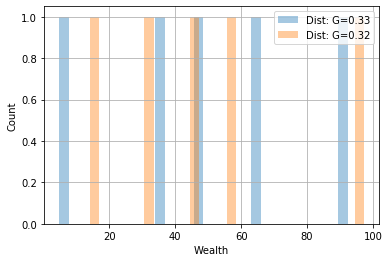

In [86]:
sim = Pure_Random(N=5,mu=50.)
sim.hist(sim.get_income_dist())
sim.run(200)
sim.hist(sim.get_income_dist())
#sim.hist(sim.get_lambda_dist())

print(max(sim.get_income_dist()))
#sim.show()



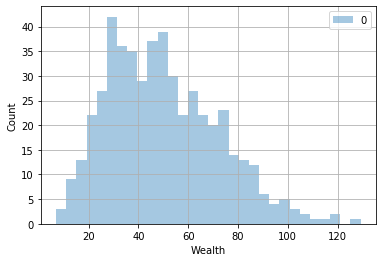

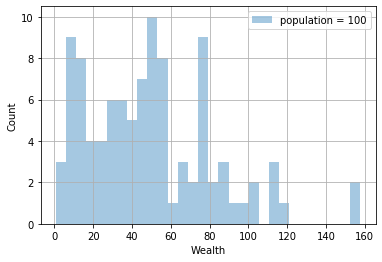